Include Yahoo Finance Library and import dataset for SPY for max period of time

In [1]:
import yfinance as yf
spy = yf.Ticker("SPY")
data = spy.history(period="max")  # Get historical data
data.to_csv("SPY_data.csv")       # Save to CSV

print(data.shape)

(8026, 8)


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#**Linear Regression**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

def create_features(df):
    """Create technical indicators as features"""
    df = df.copy()
    df['Returns'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Daily_Volatility'] = df['Returns'].rolling(window=20).std()
    df['Price_Change'] = df['Close'] - df['Open']
    df['High_Low_Diff'] = df['High'] - df['Low']
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    df = df.dropna()
    return df

def prepare_data_linear_regression(df, prediction_days=1):
    """Prepare data for linear regression"""
    df = create_features(df)
    feature_columns = ['Returns', 'MA5', 'MA20', 'Daily_Volatility',
                      'Price_Change', 'High_Low_Diff', 'Volume_MA5',
                      'Open', 'High', 'Low', 'Close', 'Volume']

    df.loc[:, 'Target'] = df['Close'].shift(-prediction_days)
    # Add binary target for classification metrics
    df.loc[:, 'Direction'] = (df['Close'].shift(-prediction_days) > df['Close']).astype(int)
    df = df.dropna()

    scaler = MinMaxScaler()
    X = scaler.fit_transform(df[feature_columns])
    y_reg = df['Target'].values
    y_clf = df['Direction'].values
    return X, y_reg, y_clf, scaler, feature_columns

def train_linear_regression(X_train, y_train):
    """Train a linear regression model"""
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def calculate_metrics(model, X_train, X_val, X_test, y_train, y_val, y_test):
    """Calculate regression metrics for all datasets"""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Calculate MSE and R2 for each set
    metrics = {
        'Training MSE': mean_squared_error(y_train, y_train_pred),
        'Training R2': r2_score(y_train, y_train_pred),
        'Validation MSE': mean_squared_error(y_val, y_val_pred),
        'Validation R2': r2_score(y_val, y_val_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Test R2': r2_score(y_test, y_test_pred)
    }

    return metrics

def calculate_classification_metrics(y_true, y_pred):
    """Calculate classification metrics for direction prediction"""
    # Convert regression predictions to binary predictions (up/down)
    y_pred_binary = (y_pred > y_true.mean()).astype(int)
    y_true_binary = (y_true > y_true.mean()).astype(int)

    metrics = {
        'Accuracy': accuracy_score(y_true_binary, y_pred_binary),
        'Precision': precision_score(y_true_binary, y_pred_binary),
        'Recall': recall_score(y_true_binary, y_pred_binary),
        'F1 Score': f1_score(y_true_binary, y_pred_binary)
    }

    return metrics

def predict_future_prices(df, model, scaler, feature_columns, days_to_predict=30):
    """Predict future stock prices for a given number of days"""
    future_dates = pd.date_range(start=df.index[-1], periods=days_to_predict + 1, freq='B')[1:]
    future_data = df.iloc[-1:].copy()
    predictions = []

    for i in range(days_to_predict):
        future_data = create_features(future_data)
        X_future = future_data[feature_columns].iloc[-1:].values
        X_future_scaled = scaler.transform(X_future)
        predicted_price = model.predict(X_future_scaled)[0]
        predictions.append(predicted_price)

        new_row = {
            'Open': predicted_price,
            'High': predicted_price * 1.01,
            'Low': predicted_price * 0.99,
            'Close': predicted_price,
            'Volume': future_data['Volume'].iloc[-1],
        }
        future_data = pd.concat([future_data, pd.DataFrame([new_row], index=[future_dates[i]])], axis=0)

    return future_dates, predictions

def plot_stock_prices(df, future_dates, future_prices):
    """Plot the historical and future stock prices"""
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Close'], label="Historical Prices", color='blue')
    plt.plot(future_dates, future_prices, label="Predicted Future Prices", color='red', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Historical and Predicted Stock Prices')
    plt.legend()
    plt.show()

def main():
    try:
        # Load and process data
        df = pd.read_csv("SPY_data.csv", index_col=0)
        df.index = pd.to_datetime(df.index)

        # Prepare data
        print("\nPreparing data and training model...")
        X, y_reg, y_clf, scaler, feature_columns = prepare_data_linear_regression(df)

        # Split data for both regression and classification
        X_train, X_temp, y_train_reg, y_temp_reg = train_test_split(X, y_reg, test_size=0.3, shuffle=False)
        X_val, X_test, y_val_reg, y_test_reg = train_test_split(X_temp, y_temp_reg, test_size=0.5, shuffle=False)

        # Train model
        model_lr = train_linear_regression(X_train, y_train_reg)

        # Calculate regression metrics
        reg_metrics = calculate_metrics(model_lr, X_train, X_val, X_test,
                                     y_train_reg, y_val_reg, y_test_reg)

        # Calculate classification metrics for each set
        train_clf_metrics = calculate_classification_metrics(y_train_reg, model_lr.predict(X_train))
        val_clf_metrics = calculate_classification_metrics(y_val_reg, model_lr.predict(X_val))
        test_clf_metrics = calculate_classification_metrics(y_test_reg, model_lr.predict(X_test))

        # Print all metrics
        print("\nRegression Metrics:")
        print("-" * 50)
        print(f"Training R2 Score: {reg_metrics['Training R2']:.4f}")
        print(f"Validation R2 Score: {reg_metrics['Validation R2']:.4f}")
        print(f"Test R2 Score: {reg_metrics['Test R2']:.4f}")

        print("\nClassification Metrics:")
        print("-" * 50)
        print("\nTraining Set Metrics:")
        for metric, value in train_clf_metrics.items():
            print(f"{metric}: {value:.4f}")

        print("\nValidation Set Metrics:")
        for metric, value in val_clf_metrics.items():
            print(f"{metric}: {value:.4f}")

        print("\nTest Set Metrics:")
        for metric, value in test_clf_metrics.items():
            print(f"{metric}: {value:.4f}")

        # Predict and plot future prices
        future_dates, predictions = predict_future_prices(df, model_lr, scaler, feature_columns)
        plot_stock_prices(df, future_dates, predictions)

    except FileNotFoundError:
        print("Error: SPY_data.csv file not found. Please ensure the file exists in the current directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

<ipython-input-3-30bfedbf4b2c>:119: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df.index = pd.to_datetime(df.index)



Preparing data and training model...

Regression Metrics:
--------------------------------------------------
Training R2 Score: 0.9992
Validation R2 Score: 0.9972
Test R2 Score: 0.9966

Classification Metrics:
--------------------------------------------------

Training Set Metrics:
Accuracy: 0.9893
Precision: 0.9887
Recall: 0.9901
F1 Score: 0.9894

Validation Set Metrics:
Accuracy: 0.9950
Precision: 0.9951
Recall: 0.9951
F1 Score: 0.9951

Test Set Metrics:
Accuracy: 0.9842
Precision: 0.9823
Recall: 0.9840
F1 Score: 0.9831
An error occurred: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by MinMaxScaler.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# **Logistic Regression**

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


def create_features(df):
    """Create technical indicators as features"""
    df['Returns'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Daily_Volatility'] = df['Returns'].rolling(window=20).std()
    df['Price_Change'] = df['Close'] - df['Open']
    df['High_Low_Diff'] = df['High'] - df['Low']
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    df = df.dropna()  # Drop NaN values
    return df


def prepare_data_logistic_regression(df, prediction_days=1):
    """Prepare data for logistic regression (binary classification)"""
    df = create_features(df)
    feature_columns = ['Returns', 'MA5', 'MA20', 'Daily_Volatility',
                       'Price_Change', 'High_Low_Diff', 'Volume_MA5',
                       'Open', 'High', 'Low', 'Close', 'Volume']

    # 🛠️ Binary Classification: 1 if price goes up, 0 if price goes down
    df = df.copy()
    df['Target'] = (df['Close'].shift(-prediction_days) > df['Close']).astype(int)  # 1 if price goes up, 0 if price goes down
    df = df.dropna()  # Drop NaN values

    if df.empty:
        raise ValueError("The DataFrame is empty after applying dropna(). Check the feature creation logic.")

    print(f"DataFrame shape after feature engineering: {df.shape}")  # Debugging information

    scaler = MinMaxScaler()
    X = scaler.fit_transform(df[feature_columns])
    y = df['Target'].values

    return X, y, scaler, feature_columns


def train_logistic_regression(X_train, y_train):
    """Train a logistic regression model"""
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model


def main():
    df = pd.read_csv("SPY_data.csv", index_col=0)
    df.index = pd.to_datetime(df.index, utc=True)  # Ensure datetime format

    # Prepare data for Logistic Regression
    print("\nTraining Logistic Regression Model...")
    X, y, scaler, feature_columns = prepare_data_logistic_regression(df)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    model = train_logistic_regression(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return model


if __name__ == "__main__":
    model = main()




Training Logistic Regression Model...
DataFrame shape after feature engineering: (8006, 16)

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.05      0.09       540
           1       0.55      0.97      0.70       661

    accuracy                           0.55      1201
   macro avg       0.55      0.51      0.40      1201
weighted avg       0.55      0.55      0.43      1201


Confusion Matrix:
[[ 28 512]
 [ 23 638]]


# Neural **Network**

<ipython-input-5-872a7b9dd9e8>:158: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df.index = pd.to_datetime(df.index)
<ipython-input-5-872a7b9dd9e8>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = (df['Close'].shift(-prediction_days) > df['Close']).astype(int)


Epoch [10/100]
Train Loss: 0.6906, Train Accuracy: 0.5366
Val Loss: 0.6889, Val Accuracy: 0.5462
Test Accuracy: 0.5504

Epoch [20/100]
Train Loss: 0.6904, Train Accuracy: 0.5366
Val Loss: 0.6889, Val Accuracy: 0.5462
Test Accuracy: 0.5504

Epoch [30/100]
Train Loss: 0.6902, Train Accuracy: 0.5366
Val Loss: 0.6889, Val Accuracy: 0.5462
Test Accuracy: 0.5504

Epoch [40/100]
Train Loss: 0.6903, Train Accuracy: 0.5366
Val Loss: 0.6887, Val Accuracy: 0.5462
Test Accuracy: 0.5504

Epoch [50/100]
Train Loss: 0.6902, Train Accuracy: 0.5366
Val Loss: 0.6888, Val Accuracy: 0.5462
Test Accuracy: 0.5504

Epoch [60/100]
Train Loss: 0.6903, Train Accuracy: 0.5366
Val Loss: 0.6887, Val Accuracy: 0.5462
Test Accuracy: 0.5504

Epoch [70/100]
Train Loss: 0.6899, Train Accuracy: 0.5366
Val Loss: 0.6889, Val Accuracy: 0.5462
Test Accuracy: 0.5504

Epoch [80/100]
Train Loss: 0.6900, Train Accuracy: 0.5366
Val Loss: 0.6889, Val Accuracy: 0.5462
Test Accuracy: 0.5504

Epoch [90/100]
Train Loss: 0.6899, Train

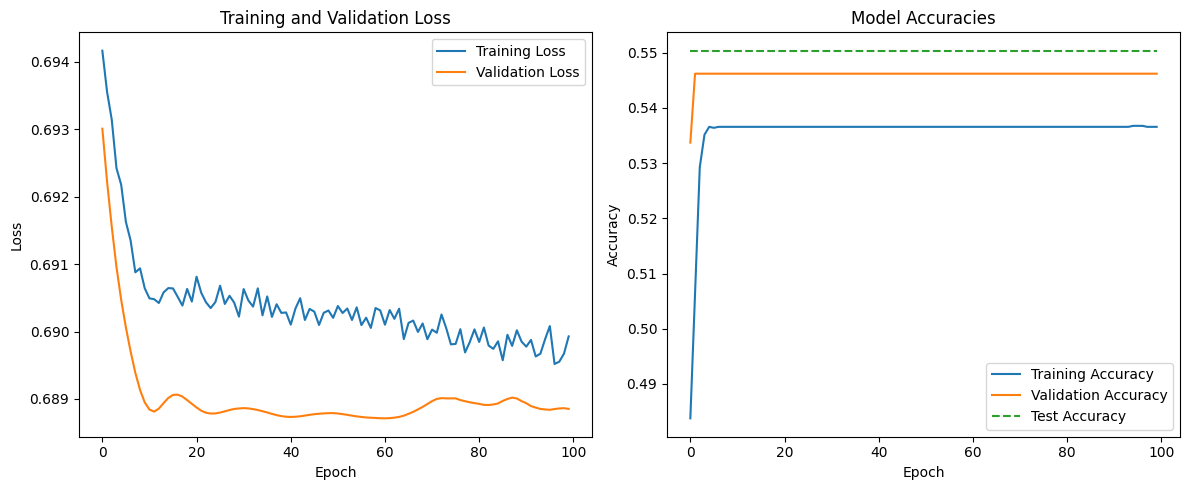


FINAL MODEL METRICS

Accuracy by Dataset:
Training Accuracy:   0.5366
Validation Accuracy: 0.5462
Test Accuracy:       0.5504

Detailed Test Metrics:
Accuracy:  0.5504
Precision: 0.5504
Recall:    1.0000
F1 Score:  0.7100


In [5]:
class StockPredictor(nn.Module):
    def __init__(self, input_size):
        super(StockPredictor, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.sigmoid(self.layer4(x))
        return x

def create_features(df):
    """Create technical indicators as features"""
    df['Returns'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Daily_Volatility'] = df['Returns'].rolling(window=20).std()
    df['Price_Change'] = df['Close'] - df['Open']
    df['High_Low_Diff'] = df['High'] - df['Low']
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    df = df.dropna()
    return df

def prepare_data(df, prediction_days=1):
    """Prepare data for neural network"""
    df = create_features(df)
    feature_columns = ['Returns', 'MA5', 'MA20', 'Daily_Volatility',
                      'Price_Change', 'High_Low_Diff', 'Volume_MA5',
                      'Open', 'High', 'Low', 'Close', 'Volume']

    df['Target'] = (df['Close'].shift(-prediction_days) > df['Close']).astype(int)
    df = df.dropna()

    scaler = MinMaxScaler()
    X = scaler.fit_transform(df[feature_columns])
    y = df['Target'].values

    return X, y, scaler, feature_columns

def calculate_accuracy(model, X, y):
    """Calculate accuracy for given data"""
    X_tensor = torch.FloatTensor(X)
    with torch.no_grad():
        outputs = model(X_tensor)
        predicted = (outputs.numpy() >= 0.5).astype(int)
    return accuracy_score(y, predicted)

def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100, learning_rate=0.001):
    """Train the neural network"""
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        # Calculate metrics
        train_losses.append(loss.item())
        train_acc = calculate_accuracy(model, X_train, y_train)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor.reshape(-1, 1))
            val_losses.append(val_loss.item())
            val_acc = calculate_accuracy(model, X_val, y_val)
            val_accuracies.append(val_acc)

            # Test
            test_acc = calculate_accuracy(model, X_test, y_test)
            test_accuracies.append(test_acc)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}')
            print(f'Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_acc:.4f}')
            print(f'Test Accuracy: {test_acc:.4f}\n')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracies': test_accuracies
    }

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        predictions = model(X_test_tensor)
        predictions = (predictions >= 0.5).numpy()

    return {
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions),
        'Recall': recall_score(y_test, predictions),
        'F1 Score': f1_score(y_test, predictions)
    }

def plot_metrics(metrics_dict):
    """Plot training, validation, and test metrics"""
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(metrics_dict['train_losses'], label='Training Loss')
    plt.plot(metrics_dict['val_losses'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(metrics_dict['train_accuracies'], label='Training Accuracy')
    plt.plot(metrics_dict['val_accuracies'], label='Validation Accuracy')
    plt.plot(metrics_dict['test_accuracies'], label='Test Accuracy', linestyle='--')
    plt.title('Model Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    df = pd.read_csv("SPY_data.csv", index_col=0)
    df.index = pd.to_datetime(df.index)

    # Prepare data
    X, y, scaler, feature_columns = prepare_data(df)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    # Create and train model
    model = StockPredictor(input_size=X.shape[1])
    training_metrics = train_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

    # Plot training metrics
    plot_metrics(training_metrics)

    # Calculate final metrics
    final_train_acc = training_metrics['train_accuracies'][-1]
    final_val_acc = training_metrics['val_accuracies'][-1]
    final_test_acc = training_metrics['test_accuracies'][-1]

    # Calculate other metrics
    test_metrics = evaluate_model(model, X_test, y_test)

    # Print final metrics
    print("\n" + "="*50)
    print("FINAL MODEL METRICS")
    print("="*50)
    print("\nAccuracy by Dataset:")
    print(f"Training Accuracy:   {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    print(f"Test Accuracy:       {final_test_acc:.4f}")

    print("\nDetailed Test Metrics:")
    print(f"Accuracy:  {test_metrics['Accuracy']:.4f}")
    print(f"Precision: {test_metrics['Precision']:.4f}")
    print(f"Recall:    {test_metrics['Recall']:.4f}")
    print(f"F1 Score:  {test_metrics['F1 Score']:.4f}")

    return model, test_metrics, training_metrics

if __name__ == "__main__":
    model, test_metrics, training_metrics = main()

# **XGBoost**

[0]	validation_0-logloss:0.67038
[1]	validation_0-logloss:0.67030
[2]	validation_0-logloss:0.67077
[3]	validation_0-logloss:0.67069
[4]	validation_0-logloss:0.67036
[5]	validation_0-logloss:0.67004
[6]	validation_0-logloss:0.66996
[7]	validation_0-logloss:0.66986
[8]	validation_0-logloss:0.66987
[9]	validation_0-logloss:0.66977
[10]	validation_0-logloss:0.66974


<ipython-input-6-be8b3737528f>:170: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df.index = pd.to_datetime(df.index)


[11]	validation_0-logloss:0.66987
[12]	validation_0-logloss:0.66987
[13]	validation_0-logloss:0.66975
[14]	validation_0-logloss:0.66953
[15]	validation_0-logloss:0.66942
[16]	validation_0-logloss:0.66902
[17]	validation_0-logloss:0.66916
[18]	validation_0-logloss:0.66910
[19]	validation_0-logloss:0.66909
[20]	validation_0-logloss:0.66902
[21]	validation_0-logloss:0.66907
[22]	validation_0-logloss:0.66950
[23]	validation_0-logloss:0.66933
[24]	validation_0-logloss:0.66984
[25]	validation_0-logloss:0.67025
[26]	validation_0-logloss:0.66994
[27]	validation_0-logloss:0.66994
[28]	validation_0-logloss:0.66984
[29]	validation_0-logloss:0.66952
[30]	validation_0-logloss:0.66932
[31]	validation_0-logloss:0.66911
[32]	validation_0-logloss:0.66921
[33]	validation_0-logloss:0.66907
[34]	validation_0-logloss:0.66875
[35]	validation_0-logloss:0.66890
[36]	validation_0-logloss:0.66944
[37]	validation_0-logloss:0.66936
[38]	validation_0-logloss:0.66942
[39]	validation_0-logloss:0.66934
[40]	validatio

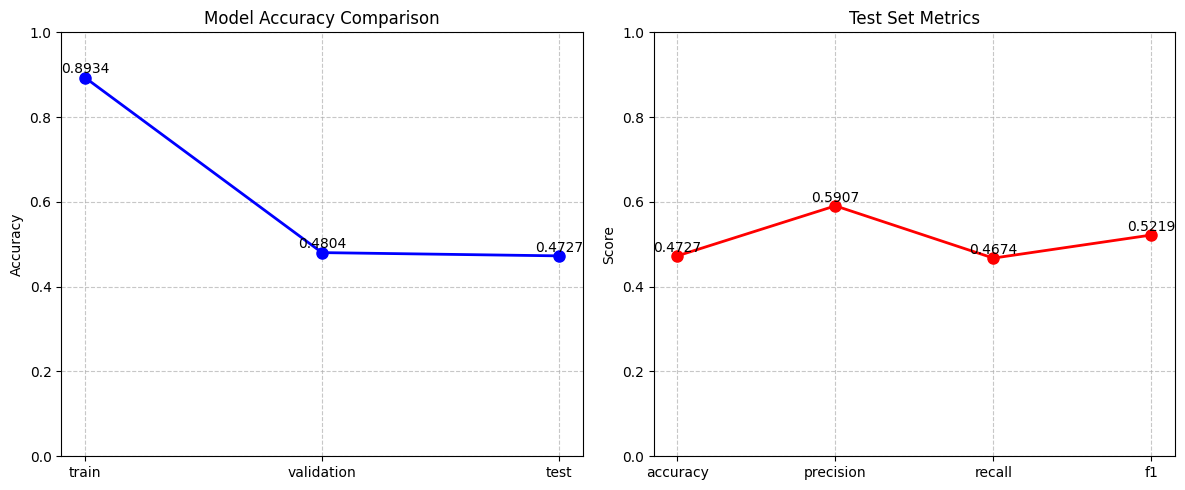

In [6]:
import xgboost as xgb


def create_features(df):
    """Create technical indicators as features"""
    # Price-based features
    df['Returns'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()

    # Volatility
    df['Daily_Volatility'] = df['Returns'].rolling(window=20).std()

    # Trading indicators
    df['RSI'] = calculate_rsi(df['Close'], periods=14)

    # Price differences
    df['Price_Change'] = df['Close'] - df['Open']
    df['High_Low_Diff'] = df['High'] - df['Low']

    return df

def calculate_rsi(prices, periods=14):
    """Calculate RSI technical indicator"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def prepare_data(df, prediction_days=5):
    """Prepare data for XGBoost model"""
    # Create features
    df = create_features(df)

    # Define features for model
    feature_columns = ['Returns', 'MA5', 'MA20', 'MA50', 'Daily_Volatility',
                      'RSI', 'Price_Change', 'High_Low_Diff',
                      'Open', 'High', 'Low', 'Volume']

    # Create target: Future price change over next 'prediction_days' days
    df['Target'] = df['Close'].shift(-prediction_days) / df['Close'] - 1

    # Create binary target (1 for price increase, 0 for decrease)
    df['Target_Binary'] = (df['Target'] > 0).astype(int)

    # Remove rows with NaN values
    df = df.dropna()

    # Split features and target
    X = df[feature_columns]
    y = df['Target_Binary']  # Using binary classification target

    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, feature_columns


def train_xgboost_model(X_train, y_train, X_val, y_val):
    """Train XGBoost model with performance tracking"""
    # Initialize model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=7,
        min_child_weight=4,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        random_state=42
    )

    # Create evaluation set
    eval_set = [(X_val, y_val)]

    # Train model
    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=True
    )

    return model


def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, feature_columns):
    """Evaluate model performance on all datasets"""
    # Make predictions for all sets
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_test)

    # Calculate metrics for all sets
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train, train_preds),
            'precision': precision_score(y_train, train_preds),
            'recall': recall_score(y_train, train_preds),
            'f1': f1_score(y_train, train_preds)
        },
        'validation': {
            'accuracy': accuracy_score(y_val, val_preds),
            'precision': precision_score(y_val, val_preds),
            'recall': recall_score(y_val, val_preds),
            'f1': f1_score(y_val, val_preds)
        },
        'test': {
            'accuracy': accuracy_score(y_test, test_preds),
            'precision': precision_score(y_test, test_preds),
            'recall': recall_score(y_test, test_preds),
            'f1': f1_score(y_test, test_preds)
        }
    }

    # Calculate feature importance
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': importance
    }).sort_values('importance', ascending=False)

    return metrics, feature_importance

def plot_metrics(metrics):
    """Plot accuracy comparison using line graphs"""
    plt.figure(figsize=(12, 5))

    # Plot accuracies
    plt.subplot(1, 2, 1)
    datasets = ['train', 'validation', 'test']
    accuracies = [metrics[ds]['accuracy'] for ds in datasets]

    plt.plot(datasets, accuracies, 'bo-', linewidth=2, markersize=8)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add value labels above each point
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

    # Plot other metrics for test set
    plt.subplot(1, 2, 2)
    test_metrics = ['accuracy', 'precision', 'recall', 'f1']
    test_values = [metrics['test'][metric] for metric in test_metrics]

    plt.plot(test_metrics, test_values, 'ro-', linewidth=2, markersize=8)
    plt.title('Test Set Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add value labels above each point
    for i, v in enumerate(test_values):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    df = pd.read_csv("SPY_data.csv", index_col=0)
    df.index = pd.to_datetime(df.index)

    # Prepare data
    X_scaled, y, scaler, feature_columns = prepare_data(df)

    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=0.2, shuffle=False
    )

    # Second split: separate training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.2, shuffle=False
    )

    # Train model
    model = train_xgboost_model(X_train, y_train, X_val, y_val)

    # Evaluate model
    metrics, feature_importance = evaluate_model(
        model, X_train, y_train, X_val, y_val, X_test, y_test, feature_columns
    )

    # Print metrics
    print("\nModel Performance Metrics:")
    print("="*50)

    print("\nAccuracy by Dataset:")
    print(f"Training Accuracy:   {metrics['train']['accuracy']:.4f}")
    print(f"Validation Accuracy: {metrics['validation']['accuracy']:.4f}")
    print(f"Test Accuracy:       {metrics['test']['accuracy']:.4f}")

    print("\nDetailed Test Metrics:")
    print(f"Accuracy:  {metrics['test']['accuracy']:.4f}")
    print(f"Precision: {metrics['test']['precision']:.4f}")
    print(f"Recall:    {metrics['test']['recall']:.4f}")
    print(f"F1 Score:  {metrics['test']['f1']:.4f}")

    print("\nTop 5 Most Important Features:")
    print(feature_importance.head().to_string())

    # Plot metrics
    plot_metrics(metrics)

    return model, scaler, metrics, feature_importance

if __name__ == "__main__":
    model, scaler, metrics, feature_importance = main()

## **CNN**

Epoch [5/50]
Train Loss: 0.0214, Val Loss: 1.5993
Train Accuracy: 0.5332, Val Accuracy: 0.4550
--------------------------------------------------
Early stopping at epoch 9

FINAL MODEL METRICS

Accuracy by Dataset:
Training Accuracy:   0.5343
Validation Accuracy: 0.5475
Test Accuracy:       0.5499

Detailed Test Metrics:
Accuracy:  0.5499
Precision: 0.5499
Recall:    1.0000
F1 Score:  0.7096


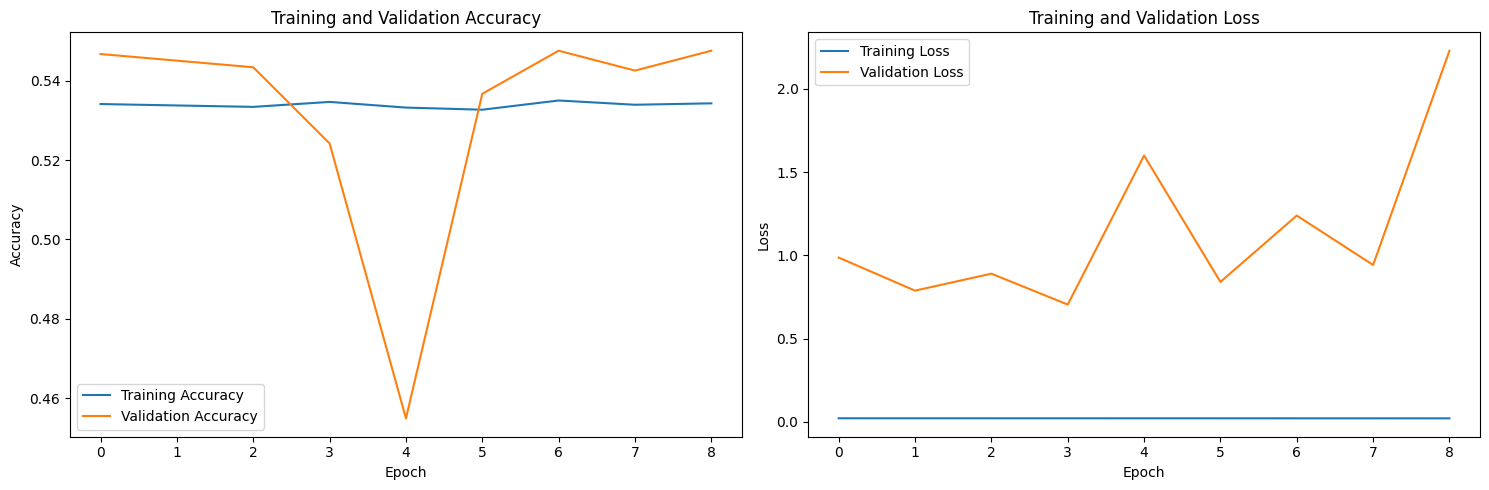

In [7]:
class CNNPredictor(nn.Module):
    def __init__(self, input_channels):
        super(CNNPredictor, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2)
        )
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2)
        )
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.mean(x, dim=2)  # Global average pooling
        x = self.fc(x)
        return x

def create_sequences(data, seq_length=20):
    """Create sequences for CNN input"""
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequence = data[i:(i + seq_length)]
        target = 1.0 if data[i + seq_length, 0] > data[i + seq_length - 1, 0] else 0.0
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences, dtype=np.float32), np.array(targets, dtype=np.float32)

def prepare_data(df, seq_length=20):
    """Prepare data for CNN model"""
    df.index = pd.to_datetime(df.index, utc=True)
    features = ['Close', 'Open', 'High', 'Low', 'Volume']
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    X, y = create_sequences(scaled_data, seq_length)
    X = np.transpose(X, (0, 2, 1))
    return X, y, scaler

def calculate_metrics(model, X, y):
    """Calculate all metrics for given data"""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X)
        outputs = model(X_tensor)
        predictions = (outputs.numpy() >= 0.5).astype(np.float32)
        return {
            'accuracy': accuracy_score(y, predictions),
            'precision': precision_score(y, predictions),
            'recall': recall_score(y, predictions),
            'f1': f1_score(y, predictions)
        }

def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """Train the CNN model with comprehensive metrics tracking"""
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val)

    # Metrics tracking
    history = {
        'train_loss': [], 'val_loss': [],
        'train_metrics': [], 'val_metrics': []
    }

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Process in batches
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.reshape(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Calculate metrics
        train_metrics = calculate_metrics(model, X_train.numpy(), y_train.numpy())
        val_metrics = calculate_metrics(model, X_val.numpy(), y_val.numpy())

        # Track metrics
        history['train_loss'].append(total_loss/len(X_train))
        history['train_metrics'].append(train_metrics)
        history['val_metrics'].append(val_metrics)

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val.reshape(-1, 1))
            history['val_loss'].append(val_loss.item())

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {total_loss/len(X_train):.4f}, Val Loss: {val_loss.item():.4f}')
            print(f'Train Accuracy: {train_metrics["accuracy"]:.4f}, Val Accuracy: {val_metrics["accuracy"]:.4f}')
            print('-' * 50)

    return history

def plot_metrics(history):
    """Plot training metrics"""
    plt.figure(figsize=(15, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot([x['accuracy'] for x in history['train_metrics']], label='Training Accuracy')
    plt.plot([x['accuracy'] for x in history['val_metrics']], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    df = pd.read_csv("SPY_data.csv", index_col=0)

    # Prepare data
    X, y, scaler = prepare_data(df)

    # Split data (70-15-15)
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))

    X_train = X[:train_size]
    X_val = X[train_size:train_size+val_size]
    X_test = X[train_size+val_size:]

    y_train = y[:train_size]
    y_val = y[train_size:train_size+val_size]
    y_test = y[train_size+val_size:]

    # Create and train model
    model = CNNPredictor(input_channels=X.shape[1])
    history = train_model(model, X_train, y_train, X_val, y_val)

    # Calculate final metrics
    train_metrics = calculate_metrics(model, X_train, y_train)
    val_metrics = calculate_metrics(model, X_val, y_val)
    test_metrics = calculate_metrics(model, X_test, y_test)

    # Print final metrics
    print("\n" + "="*50)
    print("FINAL MODEL METRICS")
    print("="*50)

    print("\nAccuracy by Dataset:")
    print(f"Training Accuracy:   {train_metrics['accuracy']:.4f}")
    print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"Test Accuracy:       {test_metrics['accuracy']:.4f}")

    print("\nDetailed Test Metrics:")
    print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall:    {test_metrics['recall']:.4f}")
    print(f"F1 Score:  {test_metrics['f1']:.4f}")

    # Plot training history
    plot_metrics(history)

    return model, history, {'train': train_metrics, 'val': val_metrics, 'test': test_metrics}

if __name__ == "__main__":
    model, history, metrics = main()